# 1. Import Libraries and Load Files

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load business file
df_b = pd.read_parquet("../datasets/parquet_file/business.parquet")

In [3]:
# Load review file
df_r = pd.read_parquet("../datasets/parquet_file/review.parquet")

# 2. Define Variables for Stability Score

### (1) Base Score

In [4]:
# -------------------------
# 1. Preprocess date columns
# -------------------------

# If no "date" column exists, try to create one from alternative timestamp columns
if "date" not in df_r.columns:
    for c in ["review_date", "created_at", "timestamp"]:
        if c in df_r.columns:
            df_r["date"] = pd.to_datetime(df_r[c], errors="coerce")
            break

# If still no valid date column is found, raise an error
if "date" not in df_r.columns:
    raise ValueError("A 'date' column is required in the review dataset.")

# Convert to datetime and remove invalid rows
df_r["date"] = pd.to_datetime(df_r["date"], errors="coerce")
df_r = df_r.dropna(subset=["date"]).sort_values(["business_id", "date"])

In [5]:
# -------------------------
# 2. Create variables for Base Score
# -------------------------

# Threshold to count "low-star" reviews
LOW_STAR_THRESHOLD = 2.0

# Aggregate review-based statistics per business
base = (
    df_r.groupby("business_id")
    .agg(
        review_count=("stars", "size"), # total number of reviews
        stars_mean=("stars", "mean"),   # average rating
        stars_std=("stars", "std"),     # rating standard deviation
        low_star_count=("stars", lambda s: (s <= LOW_STAR_THRESHOLD).sum()) # count of low ratings
    )
    .reset_index()
)

# Replace missing standard deviation
base["stars_std"] = base["stars_std"].fillna(0.0)

# Ratio of low-star reviews
base["low_star_ratio"] = base["low_star_count"] / base["review_count"]

In [6]:
# -------------------------
# 3. Filter businesses with 25+ reviews
# -------------------------

MIN_REVIEWS = 25

# Keep only businesses that meet the minimum review requirement
base = base[base["review_count"] >= MIN_REVIEWS]

# Identify valid business IDs and filter the review table accordingly
valid_ids = set(base["business_id"])
df_r = df_r[df_r["business_id"].isin(valid_ids)]

In [7]:
# -------------------------
# 4. Calculate Base Score
# -------------------------

# Raw Base Score formula:
# (average rating × log(review_count)) × (penalty for rating variance) × (penalty for low-star ratio)
base["base_score"] = (
    base["stars_mean"] * np.log1p(base["review_count"])
) * (1.0 / (1.0 + base["stars_std"])) * (1.0 - base["low_star_ratio"])

# Robust scaling: clip to the 5th–95th percentile range before normalization
p5, p95 = np.nanpercentile(base["base_score"], [5, 95])
clipped = base["base_score"].clip(lower=p5, upper=p95)

base["base_score_norm"] = (
    (clipped - p5) / max(p95 - p5, 1e-12)
).clip(0, 1)

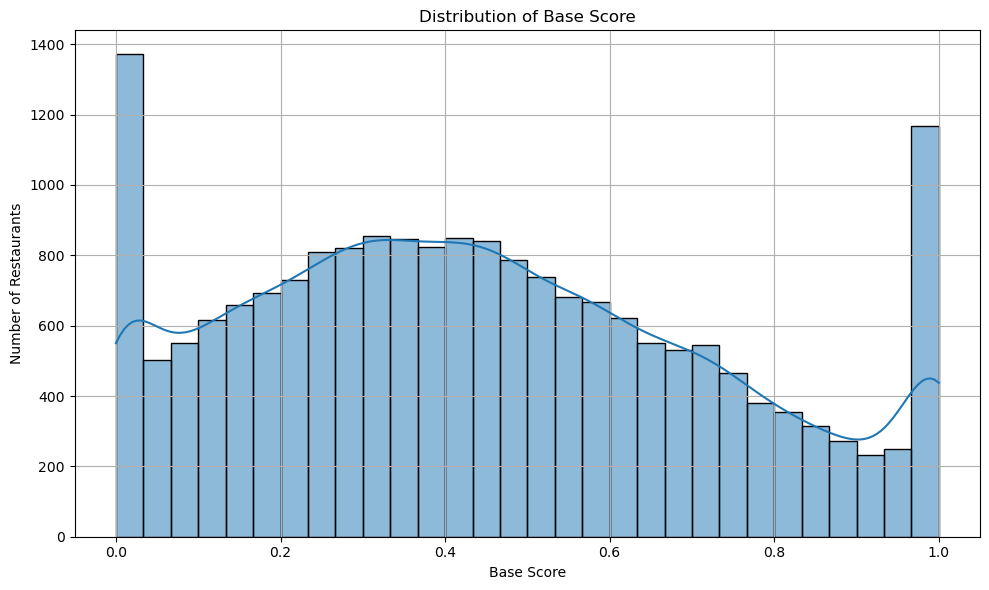

In [8]:
# ------------------------------------
# 5. Visualize the distribution of the Base Score
# ------------------------------------
plt.figure(figsize=(10, 6))
sns.histplot(base['base_score_norm'], bins=30, kde=True)

plt.title('Distribution of Base Score')
plt.xlabel('Base Score')
plt.ylabel('Number of Restaurants')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ------------------------------------
# 6. Merge into the main business dataframe
# ------------------------------------
df_b = df_b.merge(
    base[['business_id', 'base_score_norm']],
    on='business_id',
    how='left'
)

### (2) Recovery Score

In [10]:
# -------------------------
# 1. Set parameters for calculating the recovery score
# -------------------------

K_PRE = 20          # window size for pre-shock baseline
M_EVENT = 3         # window size for shock event detection
TAU_DROP = 0.8      # minimum drop in rating to flag a shock
ROLL_POST = 5       # rolling window size after the shock
DELTA_RECOV = 0.2   # tolerance when checking for recovery
SUSTAIN_N = 5       # minimum number of consecutive points to sustain recovery
MAX_DAYS = 180      # maximum time window (in days) to search for recovery

In [11]:
# -------------------------
# 2. Define function for shock detection and recovery metrics
# -------------------------
def shock_recovery_metrics(g: pd.DataFrame) -> pd.Series:
    s = g["stars"].astype(float).to_numpy()
    d = g["date"].to_numpy()
    n = len(s)

    # Rolling means for pre-shock baseline and event window
    pre_mean = pd.Series(s).rolling(K_PRE, min_periods=K_PRE).mean().to_numpy()
    post_meanM = pd.Series(s).rolling(M_EVENT, min_periods=M_EVENT).mean().to_numpy()
    roll_post = pd.Series(s).rolling(ROLL_POST, min_periods=ROLL_POST).mean().to_numpy()

    # 1) Detect the first shock point
    shock_idx = None
    for i in range(1, n):
        if np.isfinite(pre_mean[i - 1]) and np.isfinite(post_meanM[i]):
            if (pre_mean[i - 1] - post_meanM[i]) >= TAU_DROP:
                shock_idx = i
                break

    # If no shock is detected, return default mid-level scores
    if shock_idx is None:
        return pd.Series({"S_time": 0.7, "S_elas": 0.7})

    mu_pre = float(pre_mean[shock_idx - 1])   # baseline mean before shock
    mu_event = float(post_meanM[shock_idx])   # mean rating around the shock event
    t0 = pd.to_datetime(d[shock_idx])         # shock time
    max_h = pd.Timedelta(days=MAX_DAYS)       # time horizon for recovery search

    # Search for a sustained recovery period
    post_series = pd.Series(s[shock_idx:])
    post_vals = post_series.rolling(ROLL_POST, min_periods=ROLL_POST).mean().to_numpy()
    post_idx_offset = shock_idx + (ROLL_POST - 1)
    t_rec = None

    for j in range(len(post_vals)):
        if np.isnan(post_vals[j]):
            continue

        idx_global = post_idx_offset + j
        if idx_global >= n:
            break

        mu_post = post_vals[j]

        # Check if the rolling mean has returned within ±DELTA_RECOV of the pre-shock baseline
        if abs(mu_post - mu_pre) <= DELTA_RECOV:
            ok, cnt, k = True, 1, j + 1

            # Ensure the recovery is sustained for at least SUSTAIN_N consecutive points
            while cnt < SUSTAIN_N:
                if k >= len(post_vals) or np.isnan(post_vals[k]):
                    ok = False
                    break
                idx_gk = post_idx_offset + k
                if idx_gk >= n or abs(post_vals[k] - mu_pre) > DELTA_RECOV:
                    ok = False
                    break
                cnt += 1
                k += 1

            if ok:
                t_rec = pd.to_datetime(d[idx_global])
                break

        # Stop searching if we are beyond the maximum time horizon
        idx_for_time = min(shock_idx + j, n - 1)
        if (pd.to_datetime(d[idx_for_time]) - t0) > max_h:
            break

    # Time component (S_time)
    if t_rec is not None:
        days = (t_rec - t0) / np.timedelta64(1, "D")
    else:
        days = MAX_DAYS

    S_time = 1.0 / (1.0 + days / 60.0)

    # Elasticity component (S_elas)
    delta_drop = mu_pre - mu_event
    horizon_end = t0 + max_h
    mask = (d >= t0) & (d <= horizon_end)
    post_h = s[mask]

    if post_h.size >= ROLL_POST:
        post_h_roll = (
            pd.Series(post_h)
            .rolling(ROLL_POST, min_periods=ROLL_POST)
            .mean()
            .to_numpy()
        )
        valid = post_h_roll[~np.isnan(post_h_roll)]
        if valid.size > 0:
            mu_max = float(valid.max())
            S_elas = np.clip((mu_max - mu_event) / max(delta_drop, 1e-6), 0, 1)
        else:
            S_elas = 0.0
    else:
        S_elas = 0.0

    return pd.Series({"S_time": float(S_time), "S_elas": float(S_elas)})

In [12]:
# -------------------------
# 3. Apply the function per business
# -------------------------
recovery_metrics = df_r.groupby(
    "business_id", as_index=False
).apply(shock_recovery_metrics, include_groups=False)

# Fill missing values with default mid-level scores (if any)
recovery_metrics[["S_time", "S_elas"]] = recovery_metrics[["S_time", "S_elas"]].fillna(
    {"S_time": 0.7, "S_elas": 0.7}
)

In [13]:
# -------------------------
# 4. Calculate Recovery Score
# -------------------------

W_TIME = 0.6
W_ELAS = 0.4

# Weighted raw recovery score
recovery_metrics["recovery_raw"] = (
    W_TIME * recovery_metrics["S_time"] +
    W_ELAS * recovery_metrics["S_elas"]
)

# Scale recovery_raw to the [0, 1] range using MinMax scaling
scaler = MinMaxScaler()
recovery_metrics["recovery_score"] = scaler.fit_transform(
    recovery_metrics[["recovery_raw"]]
)

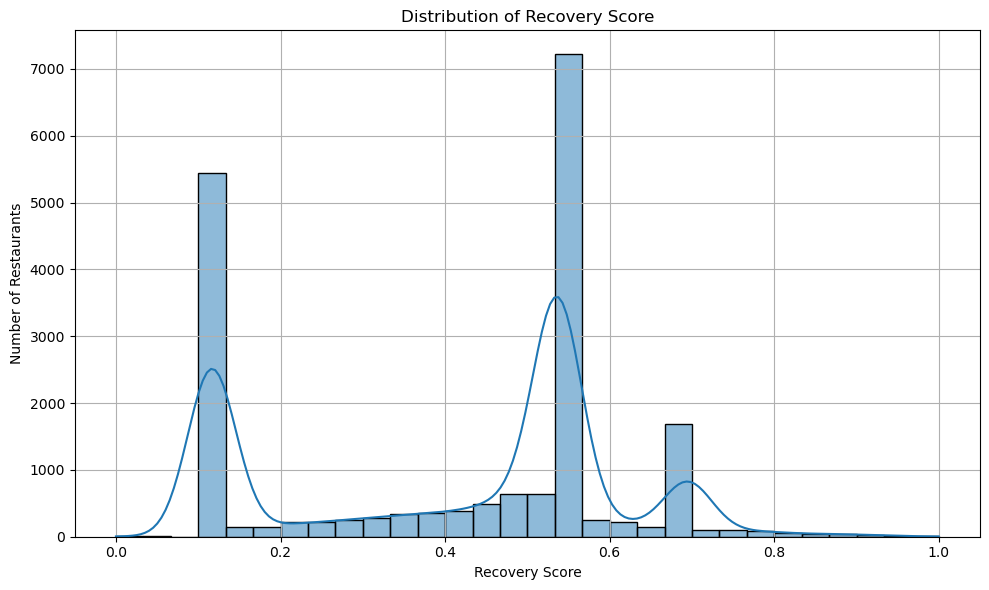

In [14]:
# -------------------------
# 5. Visualize the distribution of the Recovery Score
# -------------------------
plt.figure(figsize=(10, 6))
sns.histplot(recovery_metrics["recovery_score"], bins=30, kde=True)

plt.title("Distribution of Recovery Score")
plt.xlabel("Recovery Score")
plt.ylabel("Number of Restaurants")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ------------------------------------
# 6. Merge into the main business dataframe
# ------------------------------------
df_b = df_b.merge(
    recovery_metrics[["business_id", "recovery_score"]],
    on="business_id",
    how="left"
)

# 3. Calculate Final Stability Score

In [16]:
# Calculate the Final Stability Score

ALPHA = 0.5
df_b["stability_score"] = 100 * (
    ALPHA * df_b["base_score_norm"] 
    + (1 - ALPHA) * df_b["recovery_score"]
)

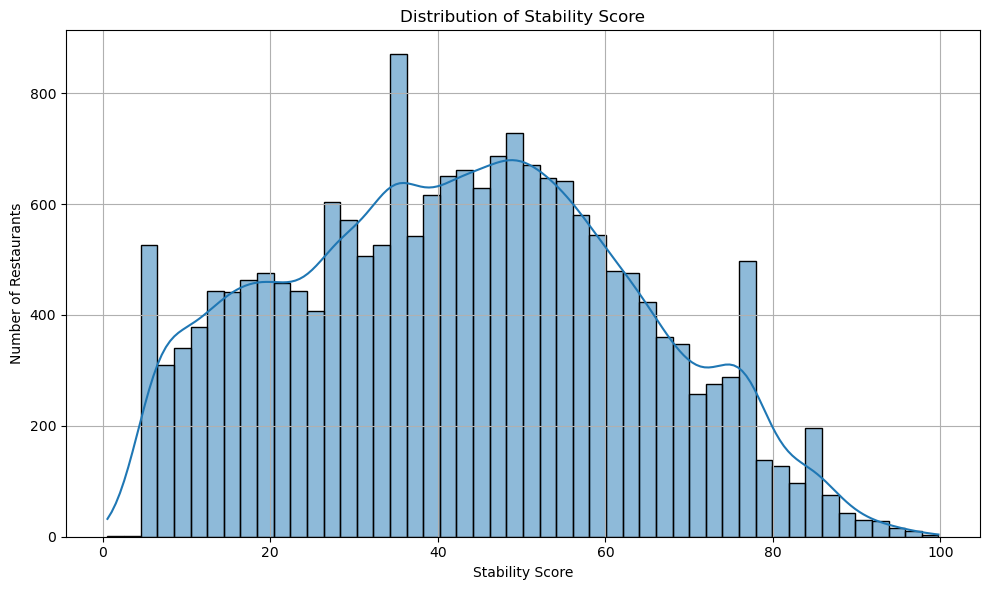

In [17]:
# Visualize the Distribution of Stability Score

plt.figure(figsize=(10, 6))
sns.histplot(df_b["stability_score"], bins=50, kde=True)

plt.title("Distribution of Stability Score")
plt.xlabel("Stability Score")
plt.ylabel("Number of Restaurants")
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# Save the final dataset as a CSV file
df_b = df_b[df_b["business_id"].isin(valid_ids)]
df_b.drop(columns=['base_score_norm', 'recovery_score'], inplace=True)
df_b.to_csv('../datasets/business1.csv', index=False)

In [20]:
# Save the filtered review and tip datasets as Parquet files
df_r = df_r[df_r["business_id"].isin(valid_ids)]
df_r.to_parquet("../datasets/parquet_file/review_filtered.parquet", engine="pyarrow")

df_t = pd.read_parquet("../datasets/parquet_file/tip.parquet")
df_t = df_t[df_t["business_id"].isin(valid_ids)]
df_t.to_parquet("../datasets/parquet_file/tip_filtered.parquet", engine="pyarrow")